In [1]:
import os 
import numpy as np 
import librosa 
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Specify the folder path
path = r'Dataset'

# Function to preprocess audio files
def preprocess_audio(directory, max_length=1000):
    audio_features = []
    audio_extensions = ['.mp3', '.wav', '.ogg', '.flac']  # Add more if needed
    for file in os.listdir(directory):
        if any(file.lower().endswith(ext) for ext in audio_extensions):
            file_path = os.path.join(directory, file)
            # Load audio file
            y, sr = librosa.load(file_path, sr=None)
            # Extract features (e.g., MFCCs)
            mfccs = librosa.feature.mfcc(y=y, sr=sr)
            # Pad or truncate features to fixed length
            if mfccs.shape[1] < max_length:
                pad_width = max_length - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            # Add features to list
            audio_features.append(mfccs.T)  # Transpose MFCCs matrix for time_steps x features shape
    return audio_features

# Prepare data
X = []
y = []
label_encoder = LabelEncoder()
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        folder_features = preprocess_audio(folder_path)
        X.extend(folder_features)
        # Encode folder name (class label)
        label = folder # Extract class label from folder name
        y.extend([label] * len(folder_features))

# Convert class labels to integers using label encoding
y_encoded = label_encoder.fit_transform(y)

# Convert to numpy arrays
X = np.array(X)
y_encoded = np.array(y_encoded)

In [3]:
# Define LSTM model
num_classes = len(label_encoder.classes_)
model = models.Sequential([
    layers.LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(128),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

In [4]:
# Train the model
history = model.fit(X, y_encoded, epochs=20, batch_size=32, validation_split=0.4)

Epoch 1/20
282/282 [==============================] - 89s 304ms/step - loss: 0.7096 - accuracy: 0.5321 - val_loss: 6.0942 - val_accuracy: 0.0000e+00
Epoch 2/20
282/282 [==============================] - 98s 349ms/step - loss: 0.6921 - accuracy: 0.5452 - val_loss: 7.0852 - val_accuracy: 0.0000e+00
Epoch 3/20
282/282 [==============================] - 102s 360ms/step - loss: 0.6905 - accuracy: 0.5432 - val_loss: 6.8409 - val_accuracy: 0.0000e+00
Epoch 4/20
282/282 [==============================] - 95s 337ms/step - loss: 0.6896 - accuracy: 0.5502 - val_loss: 7.3693 - val_accuracy: 0.0000e+00
Epoch 5/20
282/282 [==============================] - 90s 320ms/step - loss: 0.6896 - accuracy: 0.5529 - val_loss: 8.0077 - val_accuracy: 0.0000e+00
Epoch 6/20
282/282 [==============================] - 106s 375ms/step - loss: 0.6891 - accuracy: 0.5500 - val_loss: 7.0827 - val_accuracy: 0.0000e+00
Epoch 7/20
282/282 [==============================] - 100s 354ms/step - loss: 0.6882 - accuracy: 0.5554 

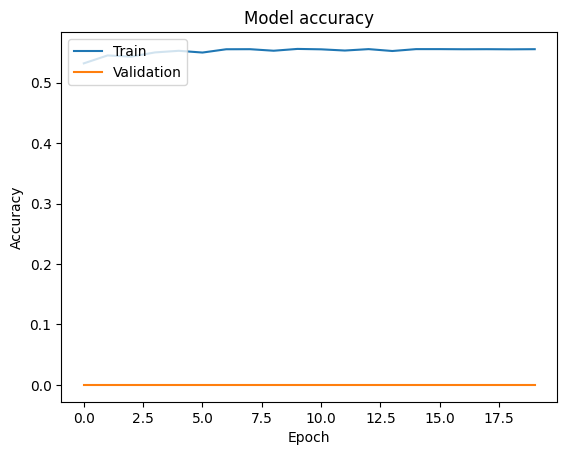

In [5]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

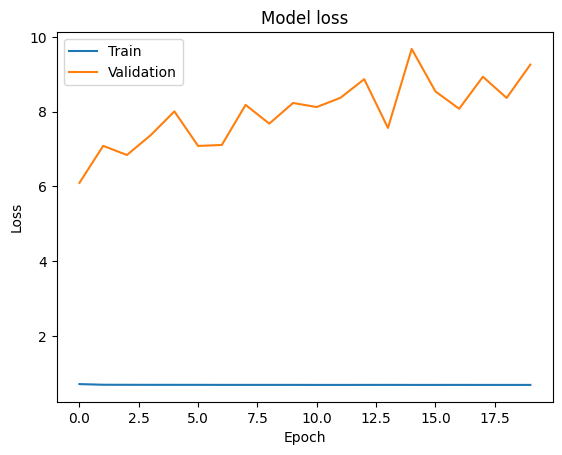

In [6]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [7]:
# Evaluate the model on validation data using CPU to avoid GPU memory issues
with tf.device('/CPU:0'):
    validation_loss, validation_accuracy = model.evaluate(X, y_encoded, verbose=0)

print("Validation Accuracy:", validation_accuracy)
print("Validation Loss:", validation_loss)


Validation Accuracy: 0.3333333432674408
Validation Loss: 4.116663932800293


In [8]:
# Save the model
model.save("LSTM_LANGUAGE.h5")

In [11]:
!pip install pyaudio

   ---------------------------------------- 0.0/164.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/164.1 kB ? eta -:--:--
   ------- -------------------------------- 30.7/164.1 kB 1.3 MB/s eta 0:00:01
   ------------------- -------------------- 81.9/164.1 kB 1.1 MB/s eta 0:00:01
   ---------------------------------- ----- 143.4/164.1 kB 1.1 MB/s eta 0:00:01
   -------------------------------------  163.8/164.1 kB 893.0 kB/s eta 0:00:01
   -------------------------------------- 164.1/164.1 kB 818.2 kB/s eta 0:00:00


In [12]:
import pyaudio
import wave

def record_audio(file_path, duration=5, sample_rate=44100, chunk_size=1024, format=pyaudio.paInt16, channels=1):
    audio = pyaudio.PyAudio()

    # Open audio stream
    stream = audio.open(format=format,
                        channels=channels,
                        rate=sample_rate,
                        input=True,
                        frames_per_buffer=chunk_size)

    print("Recording...")
    frames = []
    for _ in range(0, int(sample_rate / chunk_size * duration)):
        data = stream.read(chunk_size)
        frames.append(data)

    print("Finished recording.")

    # Stop and close the audio stream
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # Save the recorded audio to a WAV file
    with wave.open(file_path, 'wb') as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(audio.get_sample_size(format))
        wf.setframerate(sample_rate)
        wf.writeframes(b''.join(frames))

    print("Audio saved to:", file_path)

# Specify the file path to save the recorded audio
file_path = "recorded_audio.wav"

# Record audio for 5 seconds and save it to the specified file path
record_audio(file_path, duration=5)


Recording...
Finished recording.
Audio saved to: recorded_audio.wav


In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load the saved model
model = load_model("LSTM_LANGUAGE.h5")

# Define the label encoder
label_encoder = LabelEncoder()

# Function to preprocess live recorded audio
def preprocess_live_audio(audio_data, max_length=1000):
    # Extract features (e.g., MFCCs)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=44100)  # Adjust sample rate as per your recording device
    # Pad or truncate features to fixed length
    if mfccs.shape[1] < max_length:
        pad_width = max_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_length]
    return mfccs.T  # Transpose MFCCs matrix for time_steps x features shape

# Function to record live audio (example using PyAudio)
def record_audio(duration=5):
    import pyaudio
    import wave

    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = duration
    WAVE_OUTPUT_FILENAME = "live_audio.wav"

    audio = pyaudio.PyAudio()

    stream = audio.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=RATE,
                        input=True,
                        frames_per_buffer=CHUNK)

    print("Recording...")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("Finished recording.")

    stream.stop_stream()
    stream.close()
    audio.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(audio.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

    return WAVE_OUTPUT_FILENAME

# Record live audio
audio_file = record_audio()

# Load the recorded audio
y, sr = librosa.load(audio_file, sr=None)

# Preprocess the audio
live_audio_features = preprocess_live_audio(y)

# Reshape the data for prediction
live_audio_features = np.expand_dims(live_audio_features, axis=0)

# Predict class label using the loaded model
predictions = model.predict(live_audio_features)
predicted_class_index = np.argmax(predictions)

# Fit the label encoder with the training labels
labels = ['class1', 'class2', 'class3']  # Provide the actual class labels used during training
label_encoder.fit(labels)

# Transform the predicted class index into the actual class label
predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]

print("Predicted Class:", predicted_class)


ValueError: Could not interpret initializer identifier: {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}